# Scan $\psi$ at fixed $Q$ and $hkl_2$

This **hklpy** notebook demonstrates a diffractometer scan of angle $\psi$, the
component of the reference vector ($hkl_2$) that is perpendicular to the
scattering vector ($Q$).  In this schematic:

<img src="../_static/psi-angle.png" width="400" />

color | description
--- | ---
blue | incoming and exiting X-ray beams
green | scattering vector ($Q$)
red | reference vector ($hkl_2$)
black | rotation ($\psi$) around $Q$
black | principle cartesian axes
dark gray | sample

First, setup bluesky and build the diffractometer object.

In [1]:
from bluesky import plan_stubs as bps
from bluesky import preprocessors as bpp
from bluesky import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback
from hkl import A_KEV
from hkl import new_lattice
from hkl import SimulatedE4CV
from hkl.diffract import Diffractometer
from hkl.util import libhkl
from ophyd import Signal
from ophyd.sim import noisy_det
import databroker
import math
import numpy

bec = BestEffortCallback()
cat = databroker.temp().v2
RE = RunEngine()
RE.subscribe(cat.v1.insert)
RE.subscribe(bec)
bec.disable_plots()

UserUnits = libhkl.UnitEnum.USER

diffractometer = SimulatedE4CV("", name="diffractometer")

Configure the real-space axes so they are reported in LiveTable. Also, the
orientation reflections should be reported with other configuration information,
not as primary data.

In [2]:
for item in diffractometer.real_positioners:
    item.kind = "hinted"
diffractometer.reflections.kind = "config"

Add a sample of *vibranium*.  The cubic lattice constant is exactly $2\pi$.

In [3]:
diffractometer.calc.new_sample("vibranium", lattice=new_lattice(2 * math.pi))

HklSample(name='vibranium', lattice=LatticeTuple(a=6.283185307179586, b=6.283185307179586, c=6.283185307179586, alpha=90.0, beta=90.0, gamma=90.0), ux=Parameter(name='None (internally: ux)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uy=Parameter(name='None (internally: uy)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uz=Parameter(name='None (internally: uz)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), U=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), UB=array([[ 1.000000e+00, -6.123234e-17, -6.123234e-17],
       [ 0.000000e+00,  1.000000e+00, -6.123234e-17],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00]]), reflections=[])

Set the diffractometer's wavelength by setting the X-ray photon energy.
Orient the sample with two observed reflections and compute the $UB$ orientation matrix.

In [4]:
diffractometer.energy.put(A_KEV / 1.54)  # (8.0509 keV)

om = 29.35355
tth = 2 * om
r1 = diffractometer.calc.sample.add_reflection(
    4,
    0,
    0,
    position=diffractometer.calc.Position(tth=tth, omega=om, chi=0, phi=0),
)

r2 = diffractometer.calc.sample.add_reflection(
    0,
    4,
    0,
    position=diffractometer.calc.Position(tth=tth, omega=om, chi=90, phi=0),
)

diffractometer.calc.sample.compute_UB(r1, r2)

array([[-5.55111433e-17, -1.11022287e-16, -1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00, -1.72254627e-16],
       [ 1.00000000e+00, -6.12323400e-17, -1.16743483e-16]])

## bluesky plan_stub to move $\psi$

Create a bluesky plan stub to move $\psi$ given $hkl_2$ and $Q$.

<details>

This plan stub has been generalized to set all the extra parameters.  It makes
no assumption about any specific diffractometer geometry.  The default `mode`
can be changed with a keyword argument.  When using keyword `test=True`, the
number of `digits` reported can be changed with a keyword argument.

It is helpful to have a separate plan stub (a plan that does not generate any
data streams) to perform the steps needed to change the $\psi$ value.  For the
forward computation (hkl to angles), the procedure is:

1. select the diffractometer mode
2. set the extra parameters ($hkl_2$ and $\psi$)
3. compute angles from `forward(Q)`
4. move diffractometer to the computed angles

</details>

**NOTE**:
The $\psi$ rotation angle is an *extra* diffractometer parameter, only available
as defined by certain diffractometer modes.  It is not defined as an ophyd
`Signal` object. It cannot be scanned directly with any of the standard bluesky
plans, nor can it be moved with `bps.mv()`.  A custom plan is needed to scan
$\psi$.

In [5]:
def move_psi_forward(
    dfrct: Diffractometer,
    Q: dict,  # (h, k, l)
    extras: dict,  # (h2, k2, l2, psi)
    mode: str = "psi_constant",
    test: bool = False,
    digits: int = 5,
):
    """
    Set extras and compute forward solution given 'Q' & reference reflection 'hkl_2'.

    EXAMPLE::

        RE(
            move_psi_forward(
                diffractometer,
                Q=dict(h=2, k=1, l=0),
                extras=dict(h2=2, k2=2, l2=0, psi=25),
            )
        )
    """
    dfrct.engine.mode = mode
    extras = [extras[k] for k in dfrct.calc.parameters]
    dfrct.calc.engine._engine.parameters_values_set(extras, UserUnits)

    # TODO: When test=True, can any moves be avoided?
    solution = dfrct.forward(list(Q.values()))

    reals = []  # convert to ophyd real positioner objects
    for k, v in solution._asdict().items():
        reals.append(getattr(dfrct, k))
        reals.append(v)
    if test:

        def pos_dict(pos_tuple):
            # fmt: off
            return {
                k: round(v, digits) or 0 
                for k, v in pos_tuple._asdict().items()
            }
            # fmt: on

        result = pos_dict(dfrct.position)
        result.update(pos_dict(dfrct.real_position))
        result.update(
            dict(
                zip(
                    dfrct.calc.parameters,
                    dfrct.calc.engine._engine.parameters_values_get(UserUnits),
                )
            )
        )
        print(result)
    else:
        yield from bps.mv(*reals)

## bluesky plan to scan extra parameters such as $\psi$

Create a generalized bluesky plan that can scan $\psi$ given $Q$ & $hkl_2$.
The values of $hkl_2$ are described as constants in the ``extras`` input
dictionary. The `axis` parameter is `psi` in this example.  The `pseudos`
parameter contains the values of $Q$.

Do not provide a ``reals`` keyword.  That's a future feature. It must remain at
the default value of `None` for this example.

In [6]:
def scan_extra_parameter(
    dfrct: Diffractometer = None,
    detectors: list = [],
    axis: str = None,  # name of extra parameter to be scanned
    start: float = None,
    finish: float = None,
    num: int = None,
    pseudos: dict = None,  # h, k, l
    reals: dict = None,  # angles
    extras: dict = {},  # define all but the 'axis', these will remain constant
    md: dict = None,
):
    """
    Scan one (or more) extra diffractometer parameter(s), such as psi.

    - iterate extras as decribed:
        - set extras
        - solution = forward(pseudos)
        - move to solution
        - trigger detectors
        - read all controls
    """
    # if pseudos is None and reals is None:
    #     raise SolverError("Must define either pseudos or reals.")
    # if pseudos is not None and reals is not None:
    #     raise SolverError("Cannot define both pseudos and reals.")
    forwardTransformation = reals is None

    _md = {
        "diffractometer": {
            "name": dfrct.name,
            "geometry": dfrct.calc.geometry_name,
            "engine": dfrct.engine.name,
            "mode": dfrct.engine.mode,
            "extra_axes": dfrct.calc.parameters,
        },
        "axis": axis,
        "start": start,
        "finish": finish,
        "num": num,
        "pseudos": pseudos,
        "reals": reals,
        "extras": extras,
        "transformation": "forward" if forwardTransformation else "inverse",
    }
    _md.update(md or {})

    # Make a Signal for psi so it can be reported in LiveTable and any stored data.
    signal = Signal(name=axis, value=start)
    all_controls = detectors
    all_controls.append(dfrct)
    all_controls.append(signal)
    # TODO: controls.append(extras_device)  # TODO: need Device to report ALL extras
    all_controls = list(set(all_controls))

    @bpp.stage_decorator(detectors)
    @bpp.run_decorator(md=_md)
    def _inner():
        for value in numpy.linspace(start, finish, num=num):
            # note the new position for reporting later
            yield from bps.mv(signal, value)

            # move
            extras.update({axis: value})
            if forwardTransformation:
                yield from move_psi_forward(dfrct, Q=pseudos, extras=extras)
            else:
                pass  # TODO: inverse

            # trigger
            group = "scan_extra_parameter_detectors"
            for item in detectors:
                yield from bps.trigger(item, group=group)
            yield from bps.wait(group=group)

            # read & record the data point
            yield from bps.create("primary")
            for item in all_controls:
                yield from bps.read(item)
            yield from bps.save()

    return (yield from _inner())

Scan $\psi$ over a wide range in coarse steps.  This example chooses $Q=(210)$ and $hkl_2=(220)$.  Save the `uid` from the scan for later reference.

In [7]:
uid, = RE(
    scan_extra_parameter(
        diffractometer,
        detectors=[noisy_det,],
        pseudos=dict(h=2, k=1, l=0),
        axis="psi",
        start=0,
        finish=175,
        num=19,
        extras=dict(h2=2, k2=2, l2=0),
    ),
)



Transient Scan ID: 1     Time: 2024-09-04 17:30:55
Persistent Unique Scan ID: '211f4289-cf2e-4325-b56f-3d7d418a51a6'
New stream: 'primary'
+-----------+------------+------------+------------------+------------------+------------------+----------------------+--------------------+--------------------+--------------------+------------+
|   seq_num |       time |        psi | diffractometer_h | diffractometer_k | diffractometer_l | diffractometer_omega | diffractometer_chi | diffractometer_phi | diffractometer_tth |  noisy_det |
+-----------+------------+------------+------------------+------------------+------------------+----------------------+--------------------+--------------------+--------------------+------------+
|         1 | 17:30:55.1 |      0.000 |            2.000 |            1.000 |           -0.000 |               47.531 |            -90.000 |             90.000 |            -31.808 |      1.054 |
|         2 | 17:30:55.1 |      9.722 |            2.000 |            1.000

Get the run data from the catalog using the `uid` as an index.  View the
metadata from that run.

In [8]:
run = cat[uid]
run.metadata["start"]

Start({'axis': 'psi',
 'diffractometer': {'engine': 'hkl',
                    'extra_axes': [],
                    'geometry': 'E4CV',
                    'mode': 'bissector',
                    'name': 'diffractometer'},
 'extras': {'h2': 2, 'k2': 2, 'l2': 0},
 'finish': 175,
 'num': 19,
 'plan_name': 'scan_extra_parameter',
 'plan_type': 'generator',
 'pseudos': {'h': 2, 'k': 1, 'l': 0},
 'reals': None,
 'scan_id': 1,
 'start': 0,
 'time': 1725489055.0375087,
 'transformation': 'forward',
 'uid': '211f4289-cf2e-4325-b56f-3d7d418a51a6',
 'versions': {'bluesky': '1.13.0a3', 'ophyd': '1.9.0'}})

Create plots of each diffractometer *real* axis *v*. $\psi$ to show how the axes
moved during the scan.  Use the axis names as recorded in the databroker
catalog.

**Note**:
Detector axes (such as `tth`) remain constant as shown in the LiveTable. The plots show variations in the 8th decimal place due to machine precision.

/home/beams/JEMIAN/.conda/envs/bluesky_2024_2/lib/python3.11/site-packages/databroker/intake_xarray_core/base.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


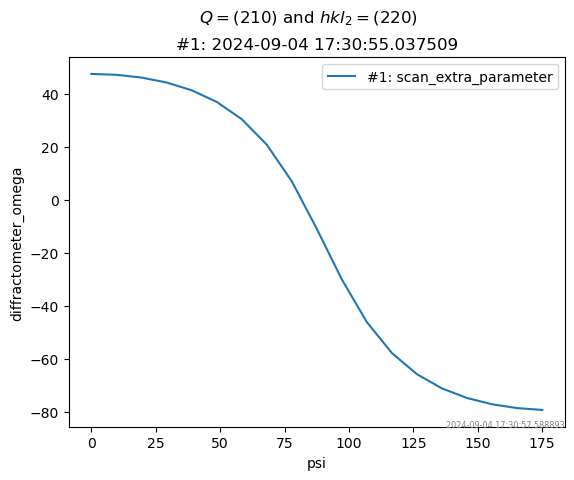

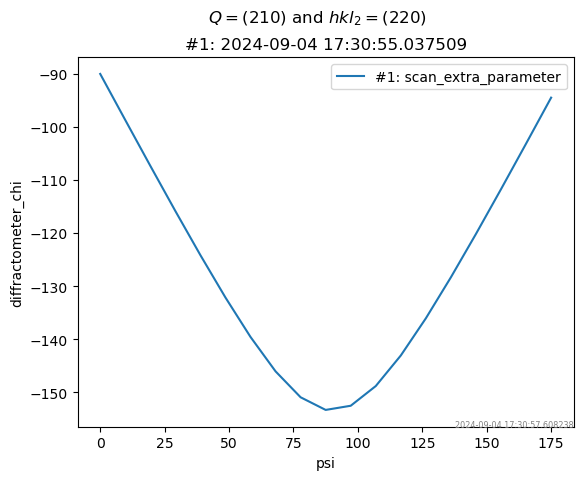

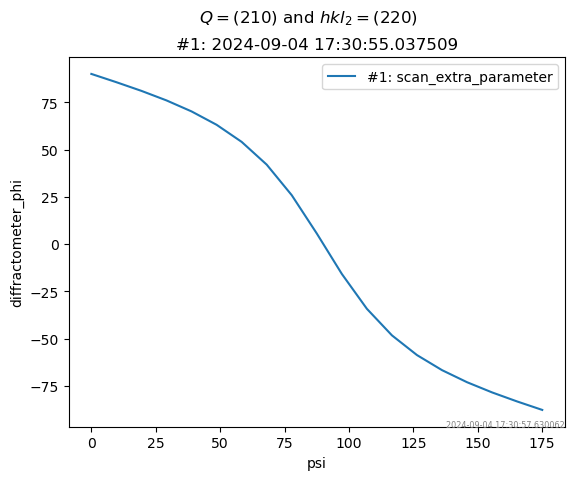

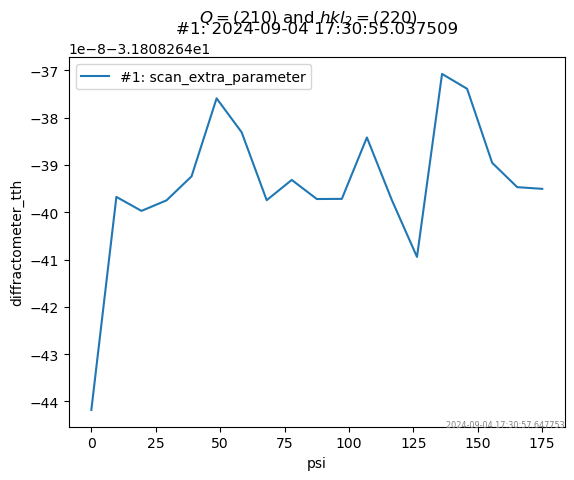

In [9]:
from apstools.utils import plotxy

title = "$Q=(210)$ and $hkl_2=(220)$"
for item in diffractometer.real_positioners:
    plotxy(run, "psi", item.name, stats=False, title=title)